### Compute equilibrium for the no-aggregate uncertainty KS model: DTCSCC

Proof of concept for computing the equilibrium for the model. Then, using the equilibrium aggregate capital, compute the stationary distribution (and decision rules) and plot them. This version uses a dtcscc model, thereby allowing continuous shocks.

This code does not make use of CompEcon, or rely on linear basis matrices. 

In [235]:
# Setup
import numpy as np
import scipy.sparse as spa
import matplotlib.pyplot as plt
from dolo.algos.dtcscc.time_iteration import time_iteration
# from dolo.algos.dtmscc.time_iteration import time_iteration_dtmscc
from dolo import *
import dolo.algos.dtcscc.distributions as dst
from dolo.numeric.misc import mlinspace
from dolo.numeric.discretization.quadrature import gauss_hermite_nodes

In [236]:
filename = 'incomplete_markets_dtcscc.yaml'
model = yaml_import(filename)

# Ne = 2
# Nkf = 1000
# kgridf = dst.fine_grid(model, Nkf)

### Solve using time iteration and plot decision rules

In [237]:
dr = time_iteration(model, with_complementarities=True, verbose=False) 

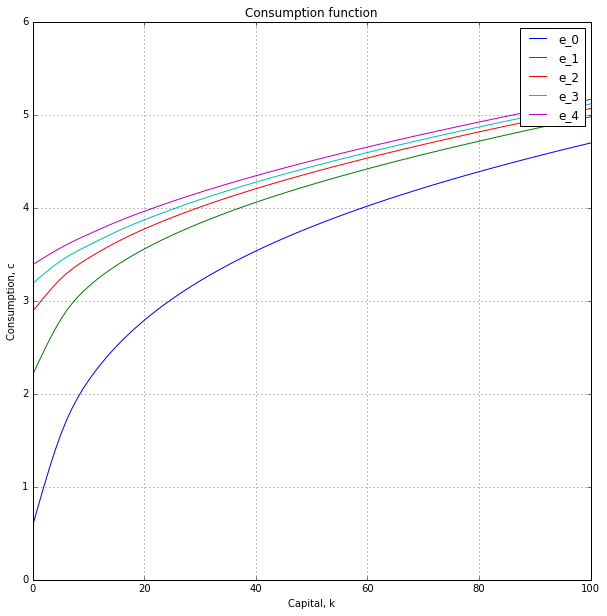

In [238]:
Nk = 100
Nf = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nf)
    drc[:, i_e] = dr(sgridf).flatten()

%matplotlib inline

plt.figure(figsize=(10, 10))

# TECHNOLOGY SHOCK
plt.plot(sgridf[:,0], drc[:,0],label='e_0')
plt.plot(sgridf[:,0], drc[:,1],label='e_1')
plt.plot(sgridf[:,0], drc[:,2],label='e_2')
plt.plot(sgridf[:,0], drc[:,3],label='e_3')
plt.plot(sgridf[:,0], drc[:,4],label='e_4')
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function')
plt.legend()
plt.grid()

### Compute stationary distribution 

In [242]:
Nf = np.array([500, 20])
def fine_grid(model, Nf):
    '''
    Construct fine grid for state variables.
    '''
    Nkf = Nf[0]
    Nef = Nf[1]    
    grid = model.get_grid()
    a = grid.a
    b = grid.b
    kgridf = np.linspace(a[0], b[0], num=Nkf)
    egridf = np.linspace(a[1], b[1], num=Nef)

    return kgridf, egridf

kgridf, egridf = fine_grid(model, Nf)

In [285]:
def dr_to_sprime(model, dr, Nf):

    Nkf = Nf[0]
    Nef = Nf[1]
    kgridf, egridf = fine_grid(model, Nf)
    trans = model.functions['transition']      # trans(s, x, e, p, out)
    parms = model.calibration['parameters']

    # NOTE: this is backwards
    sf = mlinspace(np.array([min(egridf), min(kgridf)]), np.array([max(egridf), max(kgridf)]), np.array([Nef, Nkf]))
    # NOTE: but this reverses columns so we're back to [k, e]
    sf[:,[0, 1]] = sf[:,[1, 0]]  
    
    drc = dr(sf)

    # NOTE: sprimef has second variable moving fastest. 
    sprimef = trans(sf, drc, np.zeros([Nkf*Nef,1]), parms)    # Goes off the grid bounds for kprimef 
    kprimef = sprimef[:,0]
    kprimef = np.maximum(kprimef, min(kgridf))
    kprimef = np.minimum(kprimef, max(kgridf))

    return kprimef

# kprimef.reshape(-1,1)[:100]

In [286]:
def gtilde(model, e, eps):
    rho_e = model.calibration_dict['rho_e']
    gtilde = np.maximum(np.minimum(e**rho_e*np.exp(eps), max(egridf)), min(egridf))
    return gtilde


In [291]:
# def stat_dist(model, mdr, Nkf=1000, itmaxL=5000, tolL=1e-8, verbose=False):
itmaxL = 5000
tolL = 1e-8
verbose = True

# Exogenous/Markov state variable
Nkf = Nf[0]
Nef = Nf[1]
Nq = 7
kgridf, egridf = fine_grid(model, Nf)
# NOTE: this is backwards
sf = mlinspace(np.array([min(egridf), min(kgridf)]), np.array([max(egridf), max(kgridf)]), np.array([Nef, Nkf]))
# NOTE: but this reverses columns so we're back to [k, e]
sf[:,[0, 1]] = sf[:,[1, 0]]
parms = model.calibration['parameters']

# Get the quadrature nodes for the iid normal shocks
sig_e = np.array([model.calibration_dict['sig_e']])
[eps,w] = gauss_hermite_nodes(Nq, 3*sig_e, mu=0.1)

Qe = spa.csr_matrix((Nkf*Nef, Nef))
idxlist = np.arange(0,Nkf*Nef)

for i in range(Nq):
    eprimef = gtilde(model, sf[:,1], eps[i])
    idL, idU = dst.lookup(egridf, eprimef)  # Upper and lower bracketing indices
    weighttoupper = ( (eprimef - egridf[idL])/(egridf[idU] - egridf[idL]) ).flatten()
    weighttolower = ( (egridf[idU] - eprimef)/(egridf[idU] - egridf[idL]) ).flatten()
    QeL = spa.coo_matrix((weighttolower, (idxlist, idL.flatten())), shape=(Nkf*Nef, Nef))
    QeU = spa.coo_matrix((weighttoupper, (idxlist, idU.flatten())), shape=(Nkf*Nef, Nef))
    Qe += w[i]*(QeL + QeU).tocsr()
    
# Find the state tomorrow on the fine grid
kprimef = dr_to_sprime(model, dr, Nf)

idxlist = np.arange(0,Nkf*Nef)
idL, idU = dst.lookup(kgridf, kprimef)  # Upper and lower bracketing indices

weighttoupper = ( (kprimef - kgridf[idL])/(kgridf[idU] - kgridf[idL]) ).flatten()
weighttolower = ( (kgridf[idU] - kprimef)/(kgridf[idU] - kgridf[idL]) ).flatten()

QkL = spa.coo_matrix((weighttolower, (idxlist, idL.flatten())), shape=(Nkf*Nef, Nkf))
QkU = spa.coo_matrix((weighttoupper, (idxlist, idU.flatten())), shape=(Nkf*Nef, Nkf))
Qk =(QkL + QkU).tocsr()    # convert to CSR for better sparse matrix arithmetic performance.

# TODO: Need to keep the row kronecker product in sparse matrix format
Qk = Qk.toarray()
Qe = Qe.toarray()
rowkron = Qe[:, :, None]*Qk[:, None, :]
rowkron = rowkron.reshape([Nkf*Nef, -1])
QT = spa.csr_matrix(rowkron).T

# Find stationary distribution, starting from uniform distribution
L = np.ones(Nkf*Nef)
L = L/sum(L)
for itL in range(itmaxL):
    Lnew = QT*L      # Sparse matrices can be multipled
    dL = np.linalg.norm(Lnew-L)/np.linalg.norm(L)
    if (dL < tolL):
        break

    if verbose is True:
#         if np.mod(itL, 100) == 0:
            print('Iteration = %i, dist = %f \n' % (itL, dL))

    L = np.copy(Lnew)

Iteration = 0, dist = 0.450022 

Iteration = 1, dist = 0.277297 

Iteration = 2, dist = 0.180855 

Iteration = 3, dist = 0.119405 

Iteration = 4, dist = 0.085733 

Iteration = 5, dist = 0.066713 

Iteration = 6, dist = 0.056462 

Iteration = 7, dist = 0.050874 

Iteration = 8, dist = 0.047677 

Iteration = 9, dist = 0.045679 

Iteration = 10, dist = 0.044303 

Iteration = 11, dist = 0.043264 

Iteration = 12, dist = 0.042417 

Iteration = 13, dist = 0.041686 

Iteration = 14, dist = 0.041029 

Iteration = 15, dist = 0.040425 

Iteration = 16, dist = 0.039858 

Iteration = 17, dist = 0.039322 

Iteration = 18, dist = 0.038810 

Iteration = 19, dist = 0.038320 

Iteration = 20, dist = 0.037848 

Iteration = 21, dist = 0.037392 

Iteration = 22, dist = 0.036950 

Iteration = 23, dist = 0.036520 

Iteration = 24, dist = 0.036102 

Iteration = 25, dist = 0.035692 

Iteration = 26, dist = 0.035292 

Iteration = 27, dist = 0.034898 

Iteration = 28, dist = 0.034510 

Iteration = 29, dist = 0

In [300]:
Ltmp = L.reshape([Nef, Nkf])
Ltmp.shape


0.99999999999966915

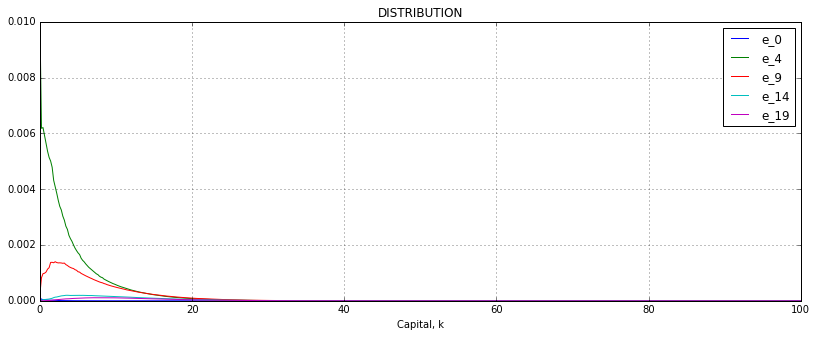

In [303]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, Ltmp[0,:],label='e_0')
plt.plot(kgridf, Ltmp[4,:],label='e_4')
plt.plot(kgridf, Ltmp[9,:],label='e_9')
plt.plot(kgridf, Ltmp[14,:],label='e_14')
plt.plot(kgridf, Ltmp[19,:],label='e_19')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

### Compute the equilibrium interest rate 

In [3]:
K = dst.solve_eqm(model, Kinit=38, tolKeq=1e-5, verbose=True)

Iteration = 	0: K=	38.0000  Kagg=	98.7978

Iteration = 	1: K=	38.0608  Kagg=	98.5146

Iteration = 	2: K=	38.4232  Kagg=	57.4972

Iteration = 	3: K=	38.6324  Kagg=	39.4280

Iteration = 	4: K=	38.6450  Kagg=	39.0059

Iteration = 	5: K=	38.6525  Kagg=	38.7659

Iteration = 	6: K=	38.6555  Kagg=	38.6748

Iteration = 	7: K=	38.6560  Kagg=	38.6564



### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [4]:
# Set model calibration to the equilibrium aggregate capital stock.
model.set_calibration(kagg=K)

# drc = time_iteration(model, with_complementarities=True, verbose=False, output_type='controls') 
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr') 

In [5]:
L, QT = dst.stat_dist(model, mdr, Nkf=Nkf, verbose=False)

### Plot the equilibrium stationary distribution and decision rules

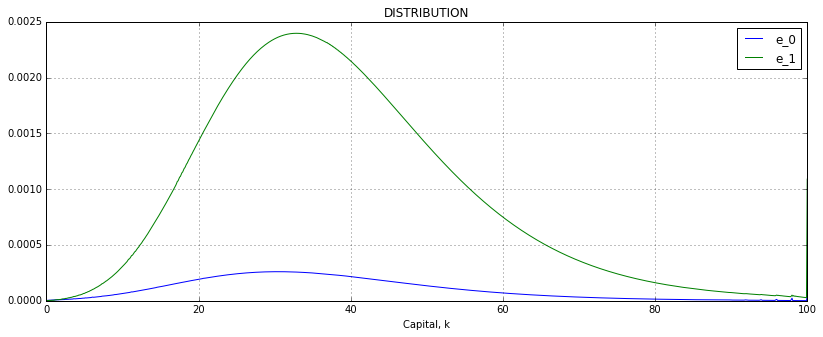

In [6]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:Nkf],label='e_0')
plt.plot(kgridf, L[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

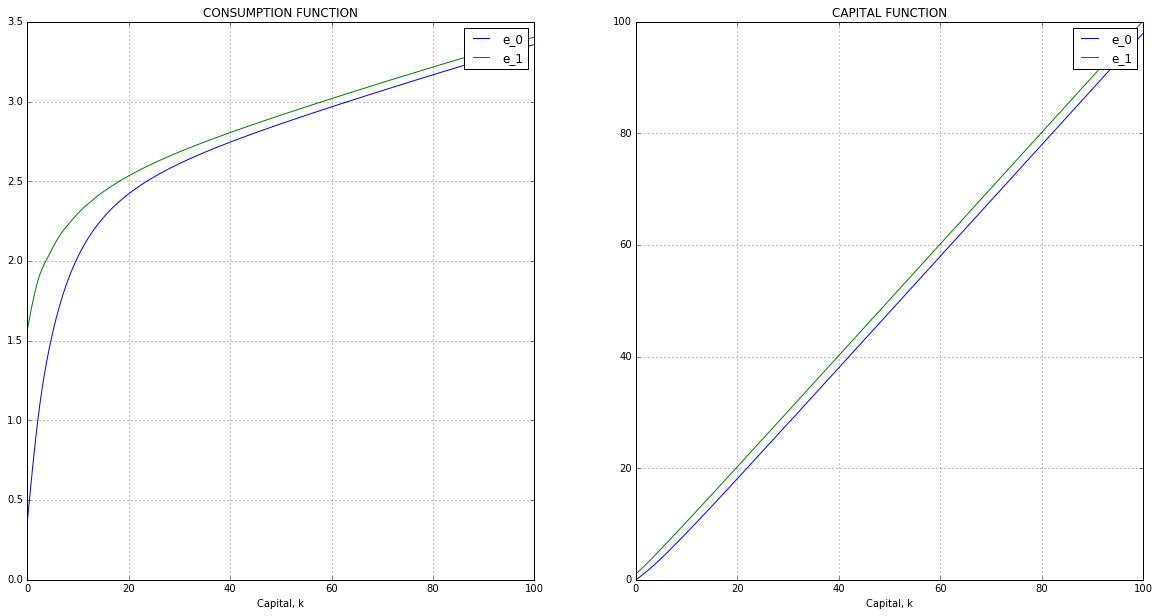

In [9]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

### Compute supply and demand curves using stat_dist function

In [ ]:
Kd, Ks, r = dst.supply_demand(model, Nkf=1000, numpoints=20, lower=37, upper=40, verbose=True)

(20, 60)

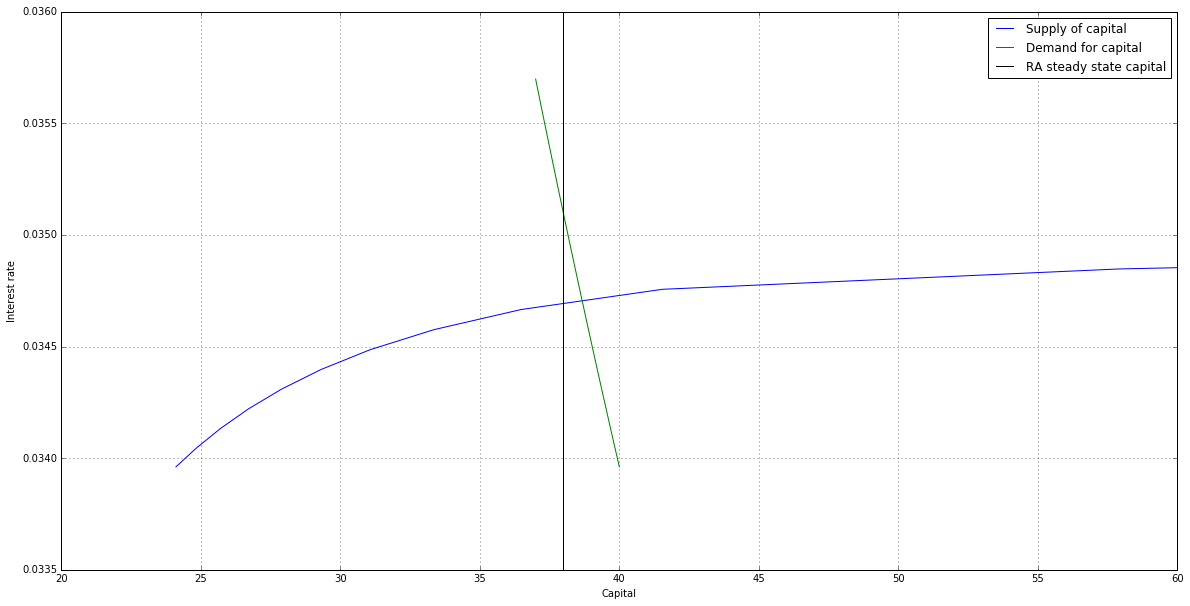

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
plt.ylim(0.0335, 0.036)
plt.xlim(20, 60)

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 